## Autograd Tensor

In [1]:
from graphviz import Digraph
import torch
def trace(root):

    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label="{ %s | %s | grad %s}" % (n.label, n.data.shape, str(n.grad.detach().cpu().numpy())), shape='record')

        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [31]:
def unbroadcast(target, grad):
    # If grad has extra leading dims, sum them away:
    while grad.dim() > target.dim():
        grad = grad.sum(dim=0)
    # For any dimension where target was size=1 (broadcast), sum over that axis:
    for i, size in enumerate(target.size()):
        if size == 1:
            grad = grad.sum(dim=i, keepdim=True)
    return grad

In [32]:
import torch

class Value:
    def __init__(self, value, _children=(), label="", _op=""):
        self.data = value
        self._prev = _children
        self._backward = lambda: None
        self.label = label
        self._op = _op
        self.grad = torch.zeros_like(value)

    def __add__(self, other):
        # Support both Value + Value and Value + Tensor
        if isinstance(other, Value):
            out = Value(self.data + other.data, _children=(self, other), _op="+")
            def _backward():
                # Sum out.grad back into self.grad and other.grad, but first undo any broadcasting:
                self.grad += unbroadcast(self.data, out.grad)
                other.grad += unbroadcast(other.data, out.grad)
            out._backward = _backward
            return out
        elif isinstance(other, torch.Tensor): # other is a Tensor
            out = Value(self.data + other, _children=(self,), _op="+")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad)
            out._backward = _backward
            return out
        else:
            raise TypeError("Unsupported operand type(s) for +: 'Value' and '{}'".format(type(other)))

    def __matmul__(self, other):
        if isinstance(other, Value):
            out = Value(self.data @ other.data, _children=(self, other), _op="@")
            def _backward():
                # d(a@b)/da = grad @ bᵀ
                self.grad += unbroadcast(self.data, out.grad @ other.data.T)
                # d(a@b)/db = aᵀ @ grad
                other.grad += unbroadcast(other.data, self.data.T @ out.grad)
            out._backward = _backward
            return out
        elif isinstance(other, torch.Tensor):
            out = Value(self.data @ other, _children=(self,), _op="@")
            def _backward():
                self.grad += unbroadcast(self.data, out.grad @ other.T)
            out._backward = _backward
            return out
        else:
            raise TypeError("Unsupported operand type(s) for @: 'Value' and '{}'".format(type(other)))

    def backward(self):
        # Initialize the gradient of the output value
        self.grad = torch.ones_like(self.data)
        # Propagate the gradients backward through the computation graph
        stack = [self]
        while stack:
            node = stack.pop()
            node._backward()
            stack.extend(node._prev)

    def __repr__(self):
        return str(f'Value: {self.data}')

    def __str__(self):
        return str(f'Value :{self.data}')

In [46]:
# To make a tensor track operations for automatic differentiation, set its `requires_grad` attribute to `True`.
w = torch.randn(1, 1, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)
a = torch.randn(2, 1, requires_grad=True)

In [34]:
w1 = w.clone().detach().requires_grad_(True)
b1 = b.clone().detach().requires_grad_(True)
a1 = a.clone().detach().requires_grad_(True)

In [35]:
a = Value(a)
a.label = 'a'
b = Value(b)
b.label = 'b'
w = Value(w)
w.label = 'w'

In [36]:
interm = a @ w
interm.label = 'interm'
z = interm + b
z.label = 'z'

In [37]:
z

Value: tensor([[0.9169],
        [1.6642]], grad_fn=<AddBackward0>)

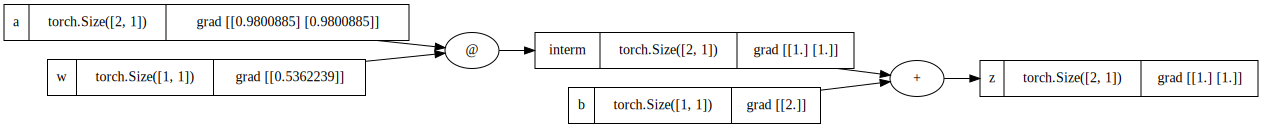

In [45]:
draw_dot(z)

In [39]:
z.grad = torch.ones_like(z.data)

- To compute gradients, call .backward() on the output tensor
- The gradients will be accumulated in the .grad attribute of the input tensors.

In [40]:
z._backward()

In [41]:
interm._backward()

In [42]:
temp = (a1 @ w1) + b1
loss = temp.sum()
loss.backward()

In [43]:
print("Gradient of the a tensor:", a1.grad)
print("Gradient of the w tensor:", w1.grad)
print("Gradient of the b tensor:", b1.grad)

Gradient of the a tensor: tensor([[0.9801],
        [0.9801]])
Gradient of the w tensor: tensor([[0.5362]])
Gradient of the b tensor: tensor([[2.]])


In [44]:
print("Gradient of the a tensor:", a.grad)
print("Gradient of the w tensor:", w.grad)
print("Gradient of the b tensor:", b.grad)

Gradient of the a tensor: tensor([[0.9801],
        [0.9801]], grad_fn=<AddBackward0>)
Gradient of the w tensor: tensor([[0.5362]], grad_fn=<AddBackward0>)
Gradient of the b tensor: tensor([[2.]])
